## Bet Against the Beta

The idea is to use CAPM to find individual stock's current monthly end beta, at start of next month, 

open long position for stocks that have low beta and open short position for stocks with high beta.

But is that also work in HK market?

To calculate the risk free rate, I use 1 month hibor fixing rate data from HKMA API. 

For HK stock price data, I use Yfinance data.

Data range from 2005-01-01 to 2024-06-30.

In [1]:
import pandas as pd
import numpy as np 
import os
import yfinance as yf
import requests
import datetime
import time
import matplotlib.pyplot as plt
import sys
import warnings
warnings.simplefilter('ignore')
from scipy import stats

try:
    data = pd.read_csv("data/hibor.csv")
    data['Date'] = pd.to_datetime(data["end_of_date"])
    data.set_index('Date',inplace=True)
    data = data.drop_duplicates(subset="end_of_date",keep='last')
    data = data.sort_index()
except:
    start_date= "2005-01-01"
    end_date= "2024-06-30"

    start_date_dt=datetime.datetime.strptime(start_date,'%Y-%m-%d')
    end_date_dt=datetime.datetime.strptime(end_date,'%Y-%m-%d')

    curr_start_date_dt=start_date_dt
    curr_end_date_dt=curr_start_date_dt +datetime.timedelta(days=120)

    data_list=[]
    while curr_start_date_dt <= end_date_dt:
        if curr_start_date_dt + datetime.timedelta(days=120)>end_date_dt:
            curr_end_date_dt=end_date_dt

        curr_start_date_str=curr_start_date_dt.strftime('%Y-%m-%d')
        curr_end_date_str= curr_end_date_dt.strftime('%Y-%m-%d')

        curr_start_date_dt+=datetime.timedelta(days=120)
        curr_end_date_dt+=datetime.timedelta(days=120)

        url="https://api.hkma.gov.hk/public/market-data-and-statistics/daily-monetary-statistics/daily-figures-interbank-liquidity"
        url+="?choose=end_of_date&from=" +curr_start_date_str+ "&to=" +curr_end_date_str

        response=requests.get(url)
        data=response.json()
        data=pd.json_normalize(data['result']['records'])
        data_list.append(data)
        time.sleep(1)
    
    data=pd.concat(data_list)
    data.to_csv("data/hibor.csv")    
    data['Date']=pd.to_datetime(data["end_of_date"])
    data.set_index('Date',inplace=True)
    data=data.drop_duplicates(subset="end_of_date",keep='last')
    data=data.sort_index()
    


In [2]:
tickers = [
           "0001.Hk","0002.HK","0003.HK","0004.HK","0005.HK","0006.HK","0011.HK","0012.HK","0014.HK","0016.HK","0017.HK","0019.HK",
           "0023.HK","0027.HK","0066.HK","0101.HK","0175.HK","0241.HK","0267.HK","0285.HK","0288.HK","0291.HK","0316.HK","0322.HK",
           "0358.HK","0384.HK","0386.HK","0388.HK","0522.HK","0546.HK","0548.HK","0552.HK","0669.HK","0688.HK","0700.HK","0728.HK",
           "0762.HK","0763.HK","0777.HK","0788.HK","0823.HK","0836.HK","0857.HK","0868.HK","0883.HK","0902.HK","0914.HK","0939.HK",
           "0941.HK","0960.HK","0966.HK","0968.HK","0981.HK","0992.HK","1024.HK","1038.HK","1044.HK","1088.HK","1093.HK","1099.HK",
           "1109.HK","1113.HK","1177.HK","1209.HK","1211.HK","1299.HK","1308.HK","1313.HK","1336.HK","1339.HK","1378.HK","1398.HK",
           "1658.HK","1800.HK","1810.HK","1818.HK","1876.HK","1928.HK","1972.HK","1929.HK","1997.HK","2013.HK","2015.HK","2018.HK",
           "2020.HK","2057.HK","2269.HK","2313.HK","2314.HK","2318.HK","2319.Hk","2328.HK","2331.HK","2359.HK","2382.HK","2388.HK",
           "2600.HK","2601.HK","2618.HK","2628.HK","2688.HK","2883.HK","2899.HK","3323.HK","3328.HK","3690.HK","3692.HK","3988.HK",
           "3993.HK","6618.HK","6690.HK","6862.HK","9618.HK","9626.HK","9633.HK","9666.HK","9866.HK","9868.HK","9888.HK","9961.HK",
           "9988.HK","9999.HK"
            ]
def load_data(symbol):

    direc = 'data/'
    os.makedirs(direc, exist_ok=True)

    file_name = os.path.join(direc, symbol + '.csv')

    if not os.path.exists(file_name):

        ticker = yf.Ticker(symbol)
        df = ticker.history(start='2005-01-01', end='2024-06-30')

        df.to_csv(file_name)

    df = pd.read_csv(file_name)
    df["Date"] = df["Date"].astype("string")
    df["Date"] = df["Date"].str[:10]
    df['Date'] = pd.to_datetime(df["Date"])
    df.set_axis(df["Date"],inplace=True)
    df['Risk_free_rate']=data["hibor_fixing_1m"]
    df = df.resample('M').agg({
        "Open":'first',
        "Close":"last",
        'Risk_free_rate':"last",
        "Date":"last"
    })
    df['this_month_return'] = (df["Close"]-df["Open"])/df["Open"]
    df["next_month_return"] = df['this_month_return'].shift(-1)
    if len(df) == 0:
        os.remove(file_name)
        return None

    return df

holder = []
ticker_with_data = []
for symbol in tickers:
    df = load_data(symbol)
    if df is not None:
        holder.append(df)
        ticker_with_data.append(symbol)

        
hsi = load_data("^HSI")
tickers = ticker_with_data[:]

print (f'Loaded data for {len(tickers)} companies')

Loaded data for 122 companies


In [3]:
trade=pd.DataFrame()
ngroup=5
for stock in holder:
    stock["market_return"] = hsi['this_month_return']
    stock["rolling_12_month_beta"] = 0
    for a in range(0, len(stock)-12 ):
        res = stats.mstats.linregress(stock["this_month_return"][(a):(a+12)],
                                    stock['market_return'][(a):(a+12)])
        stock["rolling_12_month_beta"][(a+11)]=res[0]
    stock['rolling_12_month_beta'] = stock['rolling_12_month_beta'].fillna(0)
    stock = stock[12:-1]          #drop last row as we don't have next month return for July 2024
    stock=stock.loc[stock["rolling_12_month_beta"]>=0]
    trade=pd.concat([trade,stock])
    
trade=trade.sort_index()

trade["rank"]=0
trade["rank"]=trade.groupby(trade['Date'])["rolling_12_month_beta"].transform(lambda x: 
                    pd.qcut(x.rank(method='first'), q=ngroup, labels=range(1,ngroup+1)))


## Without beta neutral stratgey:

Each month we rank and divide stocks into quintile groups to long lowest beta stocks (Quintile group 1) and short sell highest beta stocks (Quintile group 5)

<b>Negative beta stocks are not considered.

Sharpe Ratio is : 0.2647540793878648


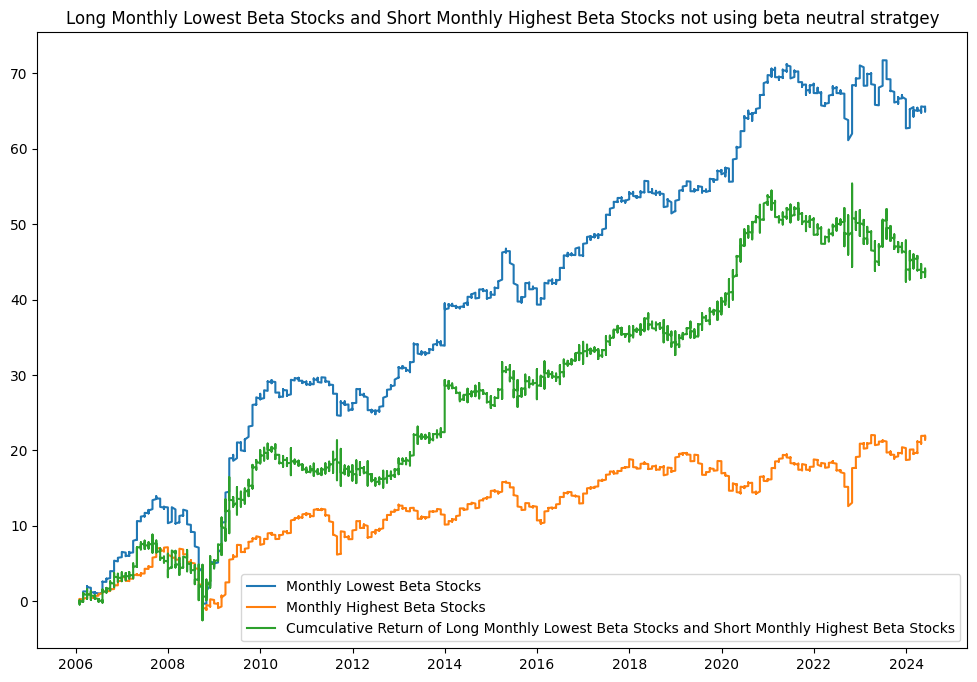

In [4]:
short_position = trade.loc[trade["rank"]==5 , "next_month_return"].cumsum()
long_position = trade.loc[trade["rank"]==1 , "next_month_return"].cumsum()
plt.figure(figsize=(12,8))
plt.plot(long_position , label = "Monthly Lowest Beta Stocks")
plt.plot(short_position , label = "Monthly Highest Beta Stocks")
cumculative_return = long_position-short_position
plt.plot(cumculative_return, label = "Cumculative Return of Long Monthly Lowest Beta Stocks and Short Monthly Highest Beta Stocks")
plt.legend()
plt.title("Long Monthly Lowest Beta Stocks and Short Monthly Highest Beta Stocks not using beta neutral stratgey")
risk = pd.concat([trade.loc[trade["rank"]==5,"next_month_return"],trade.loc[trade["rank"]==1,"next_month_return"]]).std()
sharpe = (trade.loc[trade["rank"]==1, "next_month_return"] - trade.loc[trade["rank"]==5,"next_month_return"]).mean() / risk *np.sqrt(12)
print(f"Sharpe Ratio is : {sharpe}")

## With beta neutral strategy:

Each month we divide stocks into quintile groups to long lowest beta stocks (Quintile group 1) and short sell highiest beta stocks (Quintile group 5).

But how many shares to long and short each month is based on the beta of each stock. Long lowest beta stocks (Quintile group 1) leads positive beta, 

short sell highiest beta stocks (Quintile group 5) result negative beta.

We aim to adjust the amount of shares in long and short to achieve zero beta each month.

In here, we simplify things by multiplying the return of lowest beta stocks. I did not 

<b>Negative beta stocks are not considered.


Sharpe Ratio is 0.872005424739978


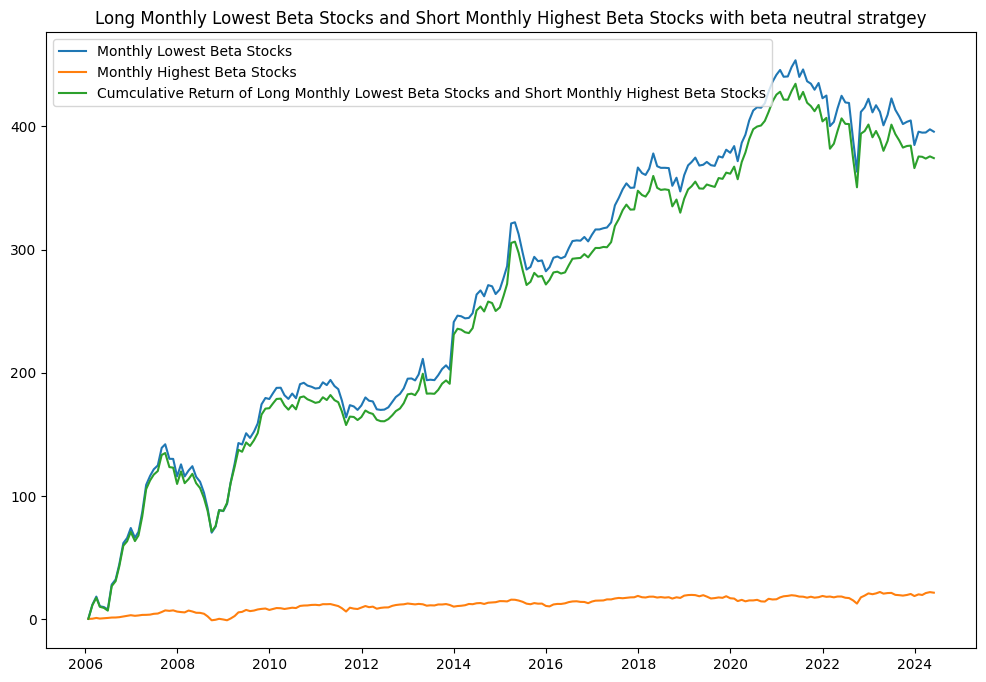

In [5]:

long_positions = pd.DataFrame(trade.loc[trade["rank"]==1])
short_positions = pd.DataFrame(trade.loc[trade["rank"]==5])

total_long_beta = long_positions.groupby(long_positions["Date"])["rolling_12_month_beta"].sum()
total_short_beta = short_positions.groupby(short_positions["Date"])["rolling_12_month_beta"].sum()

multi = total_short_beta / total_long_beta
total_long_return = long_positions.groupby(long_positions["Date"])["next_month_return"].sum() *multi
total_short_return = short_positions.groupby(short_positions["Date"])["next_month_return"].sum()

cumculative_return_low_beta = total_long_return.cumsum()
cumculative_return_high_beta = total_short_return.cumsum()

plt.figure(figsize=(12,8))
plt.plot(cumculative_return_low_beta,label="Monthly Lowest Beta Stocks")
plt.plot(cumculative_return_high_beta,label="Monthly Highest Beta Stocks")
cumculative_return = cumculative_return_low_beta-cumculative_return_high_beta
plt.plot(cumculative_return,label="Cumculative Return of Long Monthly Lowest Beta Stocks and Short Monthly Highest Beta Stocks")
plt.title("Long Monthly Lowest Beta Stocks and Short Monthly Highest Beta Stocks with beta neutral stratgey")
plt.legend()
risk = pd.concat([total_long_return,total_short_return]).std()
sharpe = (total_long_return-total_short_return).mean()/risk *np.sqrt(12)
print(f'Sharpe Ratio is {sharpe}')

## Personal thoughts about the results of the whole Bet Against Beta strategy

The results look good with and without using beta neutral strategy in Hong Kong market. Even though the HSI is just staying in a huge range for many years.

But I think there is a <b>selection bias </b> as:

1. Skipping negative beta stocks, that means I removed most of the stocks that are not following the HK market trend, 
thus most of the stocks left are going up as market go up

2. In HK not much stocks can be short sell, and I have to ensure only stocks with some turnover will be considered. 
Some stocks that are famous and actively trading but suspeneded trading such as country garden are ignored.

Besides, due to the beta neutral strategy, I have to buy much more lowest beta stocks. In theory the position is beta zero thus not affected by the market, but the <b>risk is multiplied </b>


In Hong Kong, HKEX is still having the lot size requirement for each stock.  In addition, the transaction cost is huge, each trade 0.1% stamp duty plus short sell interest (unfortunately I don't have that data). So it is <b> costly to implement such strategy in HK </b>.

To sum up, I have proved that Bet Against Beta strategy should also work in HK, but it is costly to implement. More research and backtesting is required, such as split stocks into more groups, consider negative beta stocks, and include more stocks.




